# Landau-Zener transitions
This notebook illustrates using the `toy_systems` package to simulate the classic Landau-Zener system that illustrates the behaviour of quantum states at avoided energy crossings. The LZ system is a 2-level system with a coupling of constant strength $\Omega$ between the states, and an energy difference that varies linearly over time from $\Delta E\rightarrow-\infty$ as $t\rightarrow-\infty$ thorugh $\Delta E = 0$ at $t = 0$ to $\Delta E\rightarrow\infty$ as $t\rightarrow\infty$. If we take the initial state of the system at $t \rightarrow -\infty$ to be $|\psi\rangle = |g\rangle$, the Landau-Zener formula gives the probability of an

## Imports
Start by importing the necessary packages

In [2]:
%load_ext autoreload
%autoreload 2

import joblib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import numpy as np
import qutip
from sympy import Symbol

from toy_systems.couplings import ToyCoupling, ToyEnergy
from toy_systems.decays import ToyDecay
from toy_systems.hamiltonian import Hamiltonian
from toy_systems.quantum_system import QuantumSystem
from toy_systems.states import Basis, BasisState, ToyQuantumNumbers
from toy_systems.visualization import Visualizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define states
We start by defining the two states of the system: the ground state $|g\rangle$ and the excited $|e\rangle$, which we will later set to have a decay path to $|g\rangle$:

In [3]:
g = BasisState(qn=ToyQuantumNumbers(label="g"))
e = BasisState(qn=ToyQuantumNumbers(label="e"))

# Print the states as a check
print(f"|g> = {g}")
print(f"|e> = {e}")

# Check that the states are orthogonal by taking inner product
print(f"<e|g> = {e @ g}")

|g> = |g>
|e> = |e>
<e|g> = 0


## Define basis
We use the two orthogonal states to define a basis as shown below. The indexing of the matrix and vector representations of operators is determined by the order of the states when generating the state

In [4]:
basis = Basis((g,e))
basis.print()

|0> = |g>
|1> = |e>


## Define energies
I'm going to define the system in the rotating frame so that the Hamiltonian doesn't have any quickly rotating terms of the form $e^{i\omega t}$. The detuning between the driving field and the natural frequency of the system is taken to be $\Delta(t)$ (time-varying), so I can set the energies of the two states to be $E_g = -\Delta/2$ and $E_e = \Delta/2$.

Note: the time dependence will be multiplied by the value of $\Delta$ when time-evolving the Hamiltonian.

In [5]:
Δ = Symbol('Delta') # Using sympy to generate a symbolic Hamiltonian first (to make a "Δ" type "\Delta", then press tab)
E_g = ToyEnergy([g], -Δ/2, time_dep = "t") 
E_e = ToyEnergy([e], +Δ/2, time_dep = "t") # Note the linear time-dependence

In [6]:
E_g.time_dep

't'

### Define coupling
I'm taking the strength of the driving field to vary as a Gaussian over time. This time dependence of the drive field may result in the probability of state transfer durin RAP being slightly different from 

In [7]:
Ω = Symbol('Omega') 
coupling = ToyCoupling(g, e, Ω)

## Define Hamiltonian
Now that we have the states, energies and couplings, we can define the Hamiltonian

In [10]:
H = Hamiltonian((E_g, E_e, coupling), basis)
display(H)

H =
[
[-0.5, 1.0],
[ 1.0, 0.5]]

in basis Basis: name = None

## Define decay matrix from |e> to |g>
Can add a spontaneous decay from the excited state to the ground state as shown below:

In [11]:
decay = ToyDecay(e, g, Symbol("Gamma"))

## Define a QuantumSystem
The QuantumSystem object combines the basis, Hamiltonian and decays to make setting parameters for time evolution using QuTiP more convenient.

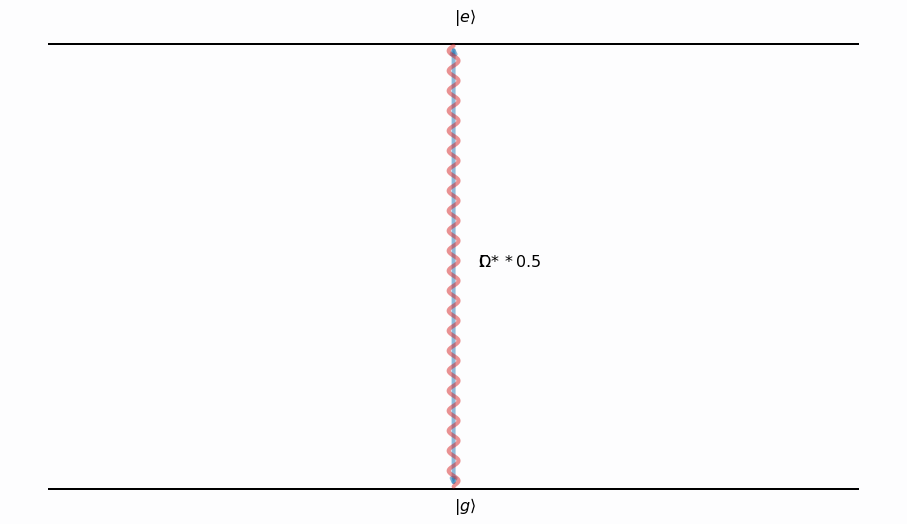

In [13]:
# Define the system
system = QuantumSystem(
    basis=basis,
    couplings=[E_g, E_e, coupling],
    decays=[decay],
)
visualizer = Visualizer(system, vertical={"label":10}, horizontal={"label":0})

# Get representations of the Hamiltonian and the decays that will be accepted by qutip
Hqobj, c_qobj = system.get_qobjs()

In [14]:
Hqobj.ops[2].coeff

'Omega'

## Time-evolution using `QuTiP`
The `toy_systems` package is designed to take care of generating the Hamiltonian and collapse operators for the quantum system, and spit out a `qutip.QobjEVo`-object. The actual time-evolution is then taken care of by `qutip` (or something else if the user so desires).

In [15]:
# Get a pointer to the time-evolution arguments
args = Hqobj.args
print("Keys for setting arguments:")
print(f"args = {args}")

Keys for setting arguments:
args = {'Delta': 1, 'Omega': 1, 'Gamma': 1}


In [16]:
# Generate a Qobj representing the initial state
psi0 = (1*g).qobj(basis)

# Make operators for getting the probability of being in each state
P_g_op = qutip.Qobj((1*g).density_matrix(basis), type = "oper")
P_e_op = qutip.Qobj((1*e).density_matrix(basis), type = "oper")

# Set the parameters for the system
args["Delta"] = 1e-2 # This is actually the rate at which delta varies, i.e. dD/dt 
args["sigma"] = 2/args["Delta"] # Width of the Gaussian describing time-dependence of drive field
args["Omega"] = 1 # The maximum value of the drive field Rabi rate
args["Gamma"] = 0 


# Times at which result is requested
times = np.linspace(-40/args["Delta"], 40/args["Delta"], 40001) 

# The solver used by qutip sometimes doesn't seem to notice that adiabatic passage is supposed to be happening, so reduce max step size to 
# mitigate this 
options = qutip.solver.Options(method = 'adams', nsteps=1000000, max_step=1e2/args["Delta"],)

# Run the time-evolution
result = qutip.mesolve(Hqobj, psi0, times, c_ops = c_qobj, e_ops = [P_g_op, P_e_op], options = options)

Plot the result:

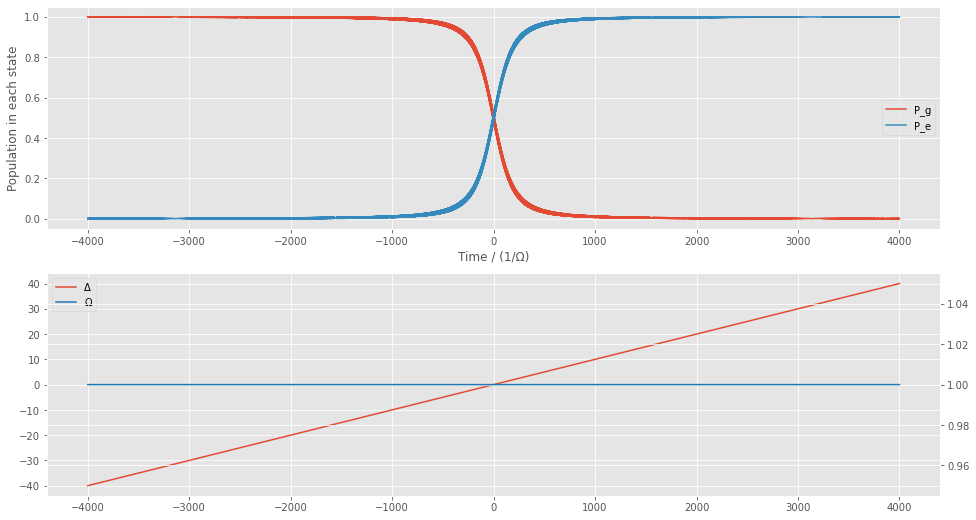

In [25]:
fig, (ax,ax2) = plt.subplots(2,1, figsize = (16,9))
ax.plot(times, result.expect[0], label = "P_g")
ax.plot(times, result.expect[1], label = "P_e")
ax.legend()
ax.set_xlabel("Time / (1/Ω)")
ax.set_ylabel("Population in each state")

# Plot the coupling strength and detuning also
ax2c = ax2.twinx()
# ax2.grid(False)
# ax2c.grid(False)
ln1 = ax2.plot(times, E_e.eval(times, args), label = "Δ")
ln2 = coupling.plot_time_dep(times, args, ax = ax2c, label = 'Ω', c = 'tab:blue')
ax2c.set_ylabel('')
ax2.legend(ln1+ln2, [l.get_label() for l in (ln1 + ln2)])
 

## Testing if Landau-Zener formula applies
The famous Landau-Zener formula for the probability of adiabatic transitions assumes a constant coupling strength and a linear detuning ramp. Under these conditions the probability of staying in the initial state can be solved for exactly and is given by $P_{ini} = 1-\exp\left(-2\pi\Omega^2/\left(\frac{dD}{dt}\right)\right)$.

To investigate, I will do a parameter scan with the detuning rate. This will also illustrate using QuTiP and parallelization.

In [43]:
# Define the function we want to run in parallel to perform the parameter scan
def parallel_func(Δ: float):
        
    # Generate a Qobj representing the initial state
    psi0 = (1*g).qobj(basis)

    # Make operators for getting the probability of being in each state
    P_g_op = qutip.Qobj((1*g).density_matrix(basis), type = "oper")
    P_e_op = qutip.Qobj((1*e).density_matrix(basis), type = "oper")
    
    args = {}
    
    # Set the parameters for the system
    args["Delta"] = Δ # This is actually the rate at which delta varies, i.e. dD/dt 
    args["sigma"] = 2/Δ # Width of the Gaussian describing time-dependence of drive field
    args["Omega"] = 1 # The maximum value of the drive field Rabi rate
    args["Gamma"] = 0 


    # Times at which result is requested
    times = np.linspace(-500/args["Delta"], 500/args["Delta"], 10001) 

    # The solver used by qutip sometimes doesn't seem to notice that adiabatic passage is supposed to be happening, so reduce max step size to 
    # mitigate this 
    options = qutip.solver.Options(method = 'adams', nsteps=1000000, max_step=1e2/Δ, rhs_reuse=True)

    # Run the time-evolution
    result = qutip.mesolve(Hqobj, psi0, times, args = args, c_ops = c_qobj, e_ops = [P_g_op, P_e_op], options = options)
    
    # Plot the result
    fig, ax = plt.subplots(figsize = (16,9))
    ax.plot(times, result.expect[0], label = "P_g")
    ax.plot(times, result.expect[1], label = "P_e")
    ax.legend()
    ax.set_xlabel("Time / (1/Ω)")
    ax.set_ylabel("Population in each state")
    ax.set_title(f"Δ = {Δ}")
        
    return np.mean(result.expect[0][-1000:])

# Define the values of dD/dt we want to try
Δs = 10**np.linspace(-0.5,3,30)

# Define a loop that will be excecuted in parallel using joblib
probs = (joblib.Parallel(n_jobs = 10, backend='loky', verbose = True)(joblib.delayed(parallel_func)(Δ) for Δ in Δs))

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 out of  30 | elapsed:   29.5s finished


slope: (-0.9990)*2*pi, intercept: -0.0008


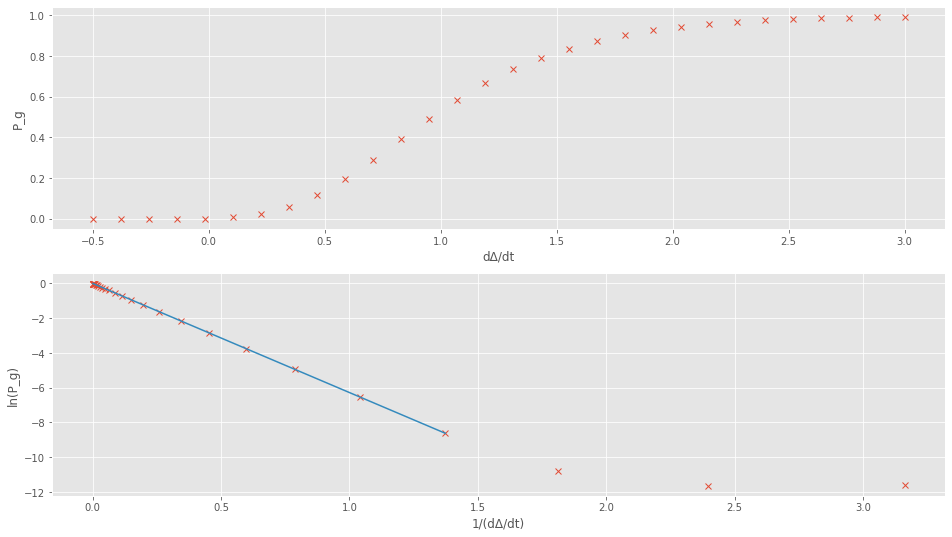

In [44]:
# Plot the result
fig, (ax, ax2) = plt.subplots(2,1, figsize = (16,9))
ax.plot(np.log10(Δs), probs, 'x')
ax.set_xlabel("dΔ/dt")
ax.set_ylabel("P_g")
ax2.plot(1/Δs, np.log(np.array(probs)), 'x')
ax2.set_xlabel("1/(dΔ/dt)")
ax2.set_ylabel("ln(P_g)")

# Fit a line to the log plot
from scipy.stats import linregress
x_fit = 1/Δs[3:]
y_fit = np.log(np.array(probs[3:]))
fit_result = linregress(x_fit, y_fit)
ax2.plot(x_fit, fit_result.slope*x_fit+fit_result.intercept)

print(f"slope: ({fit_result.slope/(2*np.pi):.4f})*2*pi, intercept: {fit_result.intercept:.4f}")

The linear fit seems quite good for the most part, and the slope and intercept are close to the expected values of $2\pi$ and 0. Strangely at the lower detuning ramp rates, the time integration is not working as well, or perhaps we are having isues with numerical precision.